# Sample weighting  
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Drenderer/klax/blob/main/docs/examples/sample_weighting.ipynb)  

This example illustrates how to assign individual weights to training samples by using [`klax.fit`][] together with a custom loss function.

To run it locally install klax with plotting capability via `pip install 'klax[plot]'`.

We'll start by importing the required packages for model creation, optimization and plotting.

In [68]:
import jax
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt

import klax

key = jr.key(0)

First, we generate some dummy data along with sample weights.

Assume our data comes from the function $f(x) = \sin(x) + \mathcal{N}(0, 0.2)$.
In practice, we don’t have direct access to the underlying function and only observe sampled points.  
Importantly, our samples are **not uniformly distributed**: we have many more data points in the region $x \in [0, 4]$ than in $x \in [4, 10]$.  
To prevent the model from focusing disproportionately on the dense region, we assign **larger sample weights** to points in the sparser region.

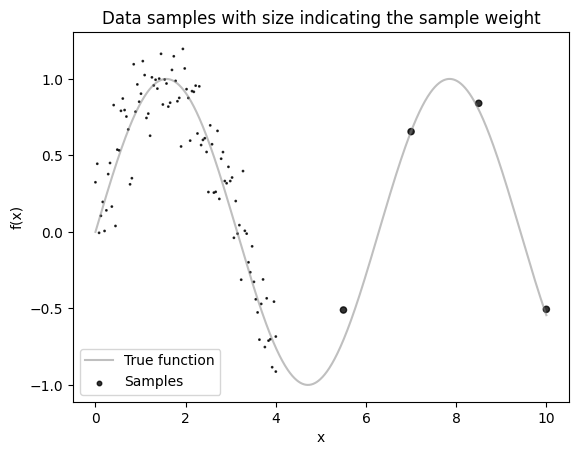

In [148]:
def f(x):
    return jnp.sin(x)


x_samples = jnp.concat([jnp.linspace(0, 4, 100), jnp.linspace(4, 10, 5)])
y_samples = f(x_samples) + 0.2 * jr.normal(key, shape=x_samples.shape)
sample_weights = jnp.where(x_samples > 4, 20, 1)

x_dense = jnp.linspace(0, 10, 1000)
y_dense = f(x_dense)

# Plot the data
plt.plot(x_dense, y_dense, c="grey", label="True function", alpha=0.5)
plt.scatter(
    x_samples, y_samples, c="k", s=sample_weights, alpha=0.8, label="Samples"
)
plt.gca().set(
    xlabel="x",
    ylabel="f(x)",
    title="Data samples with size indicating the sample weight",
)
plt.legend()
plt.show()

Let's fit a simple [`klax.nn.MLP`][] to this data.  
Let's first create a custom loss function that computes a weighted mean squared error. To pass the weights to the loss function we integrate the sample weights into the dataset.  
For comparison we also train an identical model without the sample weighting.

In [144]:
def custom_loss(model, data, batch_axis):
    inputs, targets, weights = data
    input_batch_axis, _, _ = batch_axis
    predictions = jax.vmap(model, in_axes=input_batch_axis)(inputs)
    weighted_mse = jnp.mean(weights * (predictions - targets) ** 2)
    return weighted_mse


model_key, training_key = jr.split(key)

model = klax.nn.MLP(
    in_size="scalar", out_size="scalar", width_sizes=[8, 8], key=model_key
)

model, history = klax.fit(
    model,
    data=(x_samples, y_samples, sample_weights),
    loss_fn=custom_loss,
    batch_size=32,
    steps=20_000,
    history=klax.HistoryCallback(log_every=100),
    key=training_key,
)

baseline_model = klax.nn.MLP(
    in_size="scalar", out_size="scalar", width_sizes=[8, 8], key=model_key
)

baseline_model, baseline_history = klax.fit(
    baseline_model,
    data=(x_samples, y_samples),
    batch_size=32,
    steps=20_000,
    history=klax.HistoryCallback(log_every=100),
    key=training_key,
)

Step: 0, Loss: 1.662e+01
Step: 100, Loss: 3.327e+00
Step: 200, Loss: 8.098e-01
Step: 300, Loss: 6.101e-01
Step: 400, Loss: 5.927e-01
Step: 500, Loss: 5.834e-01
Step: 600, Loss: 5.772e-01
Step: 700, Loss: 5.718e-01
Step: 800, Loss: 5.664e-01
Step: 900, Loss: 5.613e-01
Step: 1000, Loss: 5.557e-01
Step: 1100, Loss: 5.503e-01
Step: 1200, Loss: 5.447e-01
Step: 1300, Loss: 5.388e-01
Step: 1400, Loss: 5.322e-01
Step: 1500, Loss: 5.251e-01
Step: 1600, Loss: 5.174e-01
Step: 1700, Loss: 5.099e-01
Step: 1800, Loss: 5.008e-01
Step: 1900, Loss: 4.919e-01
Step: 2000, Loss: 4.828e-01
Step: 2100, Loss: 4.738e-01
Step: 2200, Loss: 4.651e-01
Step: 2300, Loss: 4.573e-01
Step: 2400, Loss: 4.512e-01
Step: 2500, Loss: 4.447e-01
Step: 2600, Loss: 4.384e-01
Step: 2700, Loss: 4.331e-01
Step: 2800, Loss: 4.292e-01
Step: 2900, Loss: 4.258e-01
Step: 3000, Loss: 4.216e-01
Step: 3100, Loss: 4.190e-01
Step: 3200, Loss: 4.162e-01
Step: 3300, Loss: 4.147e-01
Step: 3400, Loss: 4.091e-01
Step: 3500, Loss: 4.094e-01
Step

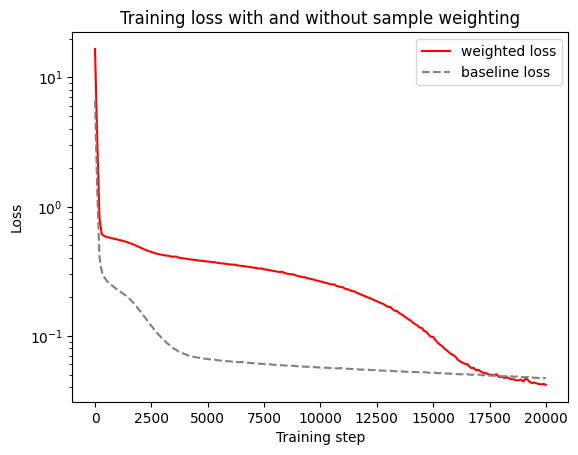

In [145]:
ax = plt.subplot()
history.plot(ax=ax, loss_options={"label": "weighted loss", "c": "red"})
baseline_history.plot(
    ax=ax, loss_options={"label": "baseline loss", "ls": "--", "c": "grey"}
)
ax.set(
    xlabel="Training step",
    ylabel="Loss",
    title="Training loss with and without sample weighting",
    yscale="log",
)
plt.legend()
plt.show()

Let's plot the model predictions.

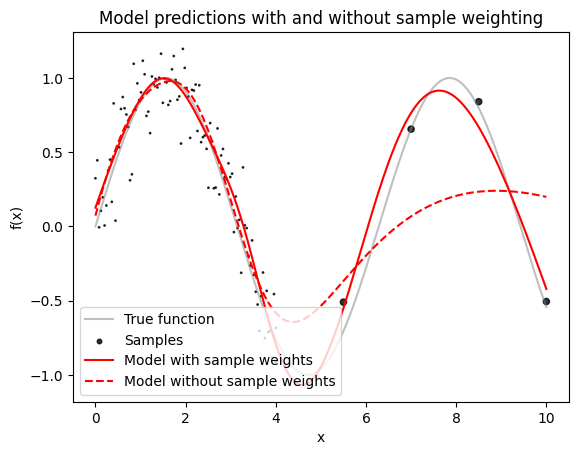

In [147]:
# Plot the data
y_pred = jax.vmap(model)(x_dense)
y_pred_baseline = jax.vmap(baseline_model)(x_dense)

plt.plot(x_dense, y_dense, c="grey", label="True function", alpha=0.5)
plt.scatter(
    x_samples, y_samples, c="k", s=sample_weights, alpha=0.8, label="Samples"
)
plt.plot(x_dense, y_pred, c="red", label="Model with sample weights")
plt.plot(
    x_dense,
    y_pred_baseline,
    c="red",
    label="Model without sample weights",
    ls="--",
)
plt.gca().set(
    xlabel="x",
    ylabel="f(x)",
    title="Model predictions with and without sample weighting",
)
plt.legend(loc=3)
plt.show()